In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

In [4]:
import nengo
import numpy as np
import nengo.spa as spa

v_scale = 0.5


model = spa.SPA()
with model:
    D = 64
    
    v = nengo.dists.UniformHypersphere(surface=True).sample(1, D)[0]
    stim = nengo.Node(v*v_scale)
    

    model.a = spa.State(D, subdimensions=4)
    
    nengo.Connection(stim, model.a.input)
    
    # add an output that computes the sum of squares for each sub-ensemble
    def sumsq(x):
        return np.sum(x**2)
    model.a.state_ensembles.add_output('sumsq', sumsq)
    
    # add the sums of squares together
    norm2 = nengo.Ensemble(n_neurons=50, dimensions=1)
    nengo.Connection(model.a.state_ensembles.sumsq, norm2,
                     transform=np.ones((1, model.a.state_ensembles.sumsq.size_out)))
                     
    # take the square root (note that this is optional, as for many uses norm2 is as good as norm)
    norm = nengo.Ensemble(n_neurons=50, dimensions=1)
    nengo.Connection(norm2, norm, function=lambda x: np.sqrt(np.abs(x)))
    
    product = nengo.networks.Product(n_neurons=500, dimensions=D)
    
    nengo.Connection(model.a.output, product.input_a)
    def inverse(x):
        if x == 0:
            return 0*x
        return 1.0/x
    pts = nengo.dists.Uniform(0.3, 1.0).sample(5000, 1)
    nengo.Connection(norm, product.input_b, function=inverse, eval_points=pts, transform=np.ones((D, 1)))
    
    p_a = nengo.Probe(model.a.output)
    p_b = nengo.Probe(product.output)

for ens in model.all_ensembles:
    ens.neuron_type = nengo.LIFRate()
    
#for ens in product.all_ensembles:
#    ens.neuron_type = nengo.Direct()
    
    

In [5]:
sim = nengo.Simulator(model)
with sim:
    sim.run(1.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

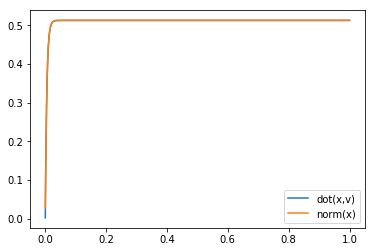

In [6]:
plt.plot(sim.trange(), np.dot(sim.data[p_a], v), label='dot(x,v)')
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_a], axis=1), label='norm(x)')
plt.legend()


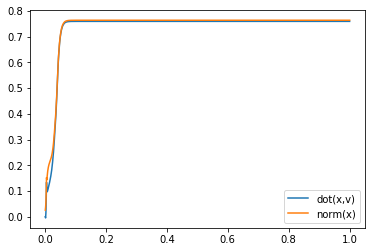

In [7]:
plt.plot(sim.trange(), np.dot(sim.data[p_b], v), label='dot(x,v)')
plt.plot(sim.trange(), np.linalg.norm(sim.data[p_b], axis=1), label='norm(x)')
plt.legend()


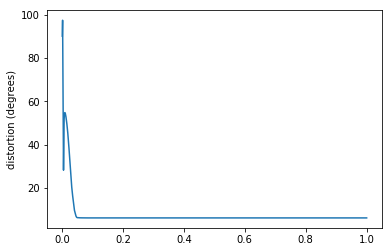

In [8]:
plt.plot(sim.trange(), 180/np.pi*np.arccos(np.dot(sim.data[p_b]/np.linalg.norm(sim.data[p_b], axis=1)[:,None], v)), label='theta')
plt.ylabel('distortion (degrees)')

In [52]:
print(model.n_neurons)

140900


In [87]:
N = 1000
D = 2
S = 500

import nengo
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=N, dimensions=D,
                         max_rates=nengo.dists.Uniform(100,100),
                         intercepts=nengo.dists.Uniform(0,0),
                         #intercepts=nengo.dists.CosineSimilarity(D+2)
                         neuron_type=nengo.RectifiedLinear(),
                         
                        )
sim = nengo.Simulator(model)

x = nengo.dists.UniformHypersphere(surface=True).sample(S, D)
x = x*np.random.uniform(0, 1, S)[:,None]
_, a = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=x)



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [88]:


norm_x = np.linalg.norm(x, axis=1)
norm_a = np.linalg.norm(a, axis=1)

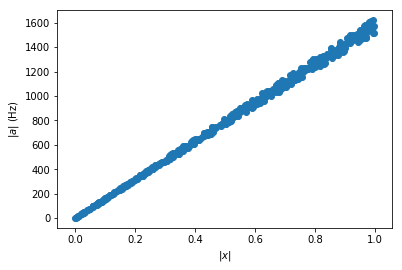

In [89]:
plt.scatter(norm_x, norm_a)
plt.xlabel("$|x|$")
plt.ylabel("$|a|$ (Hz)")


$a_i = G[\alpha_i e_i \cdot x + \beta_i]$